<a href="https://colab.research.google.com/github/Dr-Abeera-Ramla-Javaid/Langchain_work/blob/main/modules/module-2/4_trim_filter_messages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things:

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [34]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_google_genai ChatGoogleGenetrativeAI

In [35]:
from google.colab import userdata

%env GOOGLE_API_KEY = {userdata.get('GEMINI_API_KEY')}

import os
print(os.environ["GOOGLE_API_KEY"])

env: GOOGLE_API_KEY=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
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


We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

In [3]:
%env LANGCHAIN_API_KEY = {userdata.get('LANGCHAIN_API_KEY')}
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

env: LANGCHAIN_API_KEY=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


## Messages as state

First, let's define some messages.

In [15]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Abeera"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Abeera

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [26]:
!pip install --quite --upgrade langchain-google-genai



Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --quite


In [27]:
!pip uninstall langchain-google-genai
!pip install langchain-google-genai


Found existing installation: langchain-google-genai 2.0.5
Uninstalling langchain-google-genai-2.0.5:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/langchain_google_genai-2.0.5.dist-info/*
    /usr/local/lib/python3.10/dist-packages/langchain_google_genai/*
Proceed (Y/n)? y
  Successfully uninstalled langchain-google-genai-2.0.5
  Using cached langchain_google_genai-2.0.5-py3-none-any.whl.metadata (3.6 kB)
Using cached langchain_google_genai-2.0.5-py3-none-any.whl (41 kB)


In [29]:
from langchain_google_genai import ChatGoogleGenerativeAI
print("Module imported successfully!")


Module imported successfully!


In [33]:
from langchain_google_genai import ChatGoogleGenetrativeAI
llm: ChatGoogleGenetrativeAI = ChatGoogleGenetrativeAI(model= "gemini-1.5-flash", api_key = 'LANGCHAIN_API_KEY')
llm.invoke(messages)

ImportError: cannot import name 'ChatGoogleGenetrativeAI' from 'langchain_google_genai' (/usr/local/lib/python3.10/dist-packages/langchain_google_genai/__init__.py)

We can run our chat model in a simple graph with `MessagesState`.

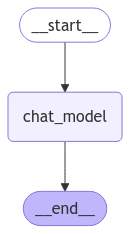

In [10]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Node
def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 API key not valid. Please pass a valid API key. [reason: "API_KEY_INVALID"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "generativelanguage.googleapis.com"
}
, locale: "en-US"
message: "API key not valid. Please pass a valid API key."
]

In [ ]:
async for m in graph.astream_events({'messages': messages}, version="v2"): # The version argument is now correctly passed as a keyword argument.
      print(m)
      print("\n--------------\n")

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='dcdce2ba-dfef-454b-8815-2beefb201928'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='314874d6-df07-4183-bb67-2aeded96d302')]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '8b70b221-ceba-40bc-abb5-44199db7154d', 'metadata': {}, 'parent_ids': []}

--------------

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='dcdce2ba-dfef-454b-8815-2beefb201928'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='314874d6-df07-4183-bb67-2aeded96d302')]}}, 'name': '__start__', '

## Reducer

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

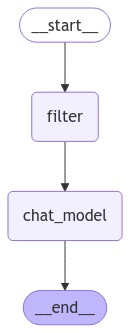

In [ ]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState) -> MessagesState:
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are fascinating creatures.  But the world of ocean mammals goes way beyond whales! Here are some others to dive into:

**Marine Mammals:**

* **Dolphins:** These intelligent and social creatures are found in all oceans.  There are over 40 different species, each with unique characteristics and behaviors.
* **Porpoises:**  Often confused with dolphins, porpoises are smaller, stockier, and have a triangular dorsal fin.
* **Seals:**  These pinnipeds (meaning "fin-footed") spend most of their time in the water but come ashore to rest and breed.  There are two main types:  **true seals** (like har

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

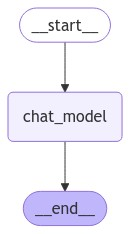

In [ ]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [ ]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [ ]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are fascinating creatures.  But the world of ocean mammals goes way beyond whales! Here are some others to dive into:

**Marine Mammals:**

* **Dolphins:** These intelligent and social creatures are found in all oceans.  There are over 40 different species, each with unique characteristics and behaviors.
* **Porpoises:**  Often confused with dolphins, porpoises are smaller, stockier, and have a triangu

In [ ]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are fascinating creatures.  But the world of ocean mammals goes way beyond whales! Here are some others to dive into:

**Marine Mammals:**

* **Dolphins:** These intelligent and social creatures are found in all oceans.  There are over 40 different species, each with unique characteristics and behaviors.
* **Porpoises:**  Often confused with dolphins, porpoises are smaller, stockier, and have a triangu

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

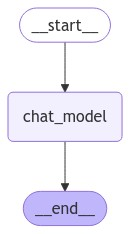

In [ ]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-1.5-flash"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [ ]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-1.5-flash"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [ ]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r